## ERDAP with erddapy example for FCOM ITAE Prawler - 2019 C2 (CKITAEPR-2A)

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 
+ Raw Science Units are what is being hosted on ERDDAP client.    
+ Salinity must be calculated from Conductivity   
+ OxyConc must be corrected for Salinity/Press   
+ Turb/Chlor must be calculated from counts   
+ TELOS ('http://heron:8080/erddap') erddap doesn't keep a divenumber value (and its not trivial to sort this data) so second erddap is hosting this data in order to keep that parameter ('http://downdraft.pmel.noaa.gov:8080/erddap') some preprocessing is happening there prior to data posting.  Incomming -> Science -> QC'd data is a source of future conversation for erddap hosting.

__Todo:__
+ Initial QC can be done   
+ csv files of converted data should be archived at end of deployment?

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2020-09-02 09:40:12.923058


### connecting and basic information

In [2]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

import seawater as sw
import calc.aanderaa_corrO2_sal as optode_O2_corr

server_url = 'http://heron:8080/erddap'
#alternate server_url = 'http://redwing:8080/erddap/tabledap/TELOF001_PRAWC_F001.html'

e = ERDDAP(server=server_url)

In [3]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAW'))

In [4]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 12 tabledap, 0 griddap, and 0 wms endpoints.'

In [5]:
prawlers = df['Dataset ID'].values
print(prawlers)

['FCOM0001_PRAWE_0001' 'FCOM0001_PRAWC_0001' 'TELO0003_PRAWE_0002'
 'TELO0003_PRAWC_0002' 'TELO9999_PRAWE_0002' 'TELO9999_PRAWC_0002'
 'TELOF001_PRAWE_F001' 'TELOF001_PRAWC_F001' 'TELOMCL0_PRAWE_MCL0'
 'TELOMCL0_PRAWC_MCL0' 'TELON001_PRAWE_N001' 'TELON001_PRAWC_N001']


In [6]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['ETimer', 'IRate', 'time', 'SRate', 'Depth'], ['time', 'Optode_Temp', 'wetlab_Chlorophyll', 'SB_Conductivity', 'SB_Depth', 'SB_Temp', 'Optode_Dissolved_O2', 'wetlab_FDOM'], ['ETimer', 'IRate', 'time', 'SRate', 'Depth'], ['wetlab_FDOM', 'time', 'Optode_Temp', 'wetlab_Chlorophyll', 'SB_Conductivity', 'SB_Depth', 'SB_Temp', 'Optode_Dissolved_O2', 'Epoch_Time'], ['ETimer', 'IRate', 'time', 'SRate', 'Depth'], ['wetlab_FDOM', 'time', 'Optode_Temp', 'wetlab_Chlorophyll', 'SB_Conductivity', 'SB_Depth', 'SB_Temp', 'Optode_Dissolved_O2', 'Epoch_Time'], ['ETimer', 'IRate', 'time', 'SRate', 'Depth'], ['wetlab_FDOM', 'time', 'Optode_Temp', 'wetlab_Chlorophyll', 'SB_Conductivity', 'SB_Depth', 'SB_Temp', 'Optode_Dissolved_O2', 'Epoch_Time'], ['ETimer', 'IRate', 'time', 'SRate', 'Depth'], ['wetlab_FDOM', 'time', 'Optode_Temp', 'wetlab_Chlorophyll', 'SB_Conductivity', 'SB_Depth', 'SB_Temp', 'Optode_Dissolved_O2', 'Epoch_Time'], ['ETimer', 'IRate', 'time', 'SRate', 'Depth'], ['wetlab_FDOM', 'time', 'O

### retrieving and plotting data

In [7]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='TELOF001_PRAWC_F001'

d.variables =  [
 'SB_Depth',
 'SB_Temp',
 'SB_Conductivity',
 'Optode_Temp',
 'Optode_Dissolved_O2',
 'wetlab_Chlorophyll',
 'wetlab_FDOM',
 "time"
]

d.constraints = {
    'time>=': '2019-08-01T00:00:00Z',
    'time<=': '2020-08-01T00:00:00Z',
}

In [8]:
d.get_download_url()

'http://heron:8080/erddap/tabledap/TELOF001_PRAWC_F001.csv?SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM,time&time>=1564617600.0&time<=1596240000.0'

In [9]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.head()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM
time (UTC),,,,,,,
2019-08-18 22:17:24+00:00,4.69,8.598,3.269,8.604,363.41,70.0,52.0
2019-08-18 22:17:32+00:00,4.67,8.599,3.270,8.604,363.38,72.0,62.0
2019-08-18 22:17:40+00:00,4.59,8.598,3.270,8.604,363.39,69.0,54.0
2019-08-18 22:17:48+00:00,4.57,8.598,3.270,8.604,363.35,70.0,53.0
2019-08-18 22:17:56+00:00,4.60,8.598,3.270,8.605,363.42,69.0,49.0


In [10]:
df.tail()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM
time (UTC),,,,,,,
2020-07-26 12:36:34+00:00,3.05,1.270,2.484,1.276,432.94,74.0,51.0
2020-07-26 12:36:42+00:00,3.11,1.270,2.484,1.276,432.98,71.0,52.0
2020-07-26 12:36:50+00:00,2.94,1.270,2.484,1.276,433.11,71.0,51.0
2020-07-26 12:36:58+00:00,2.92,1.272,2.484,1.277,433.10,75.0,54.0
2020-07-26 12:37:06+00:00,2.95,1.270,2.484,1.283,432.86,75.0,50.0


#### Temperature

In [11]:
#qc
df['SB_Temp'][df['SB_Temp']>20]=np.nan

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

Text(0, 0.5, 'Depth (m)')

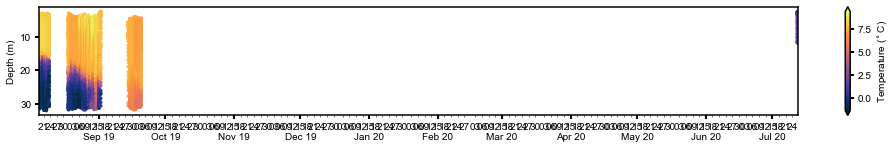

In [14]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['SB_Temp'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.thermal)
ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


In [15]:
print("""
max temp: {0:0.4}
min temp: {1:0.4}""".format(df['SB_Temp'].max(), df['SB_Temp'].min()))


max temp: 9.447
min temp: -1.337


#### Salinity

In [16]:
### calculate salinity from conductivity
df['Salinity (PSU)'] = sw.salt(r=df['SB_Conductivity']/4.2914,t=df['SB_Temp'],p=df['SB_Depth'])

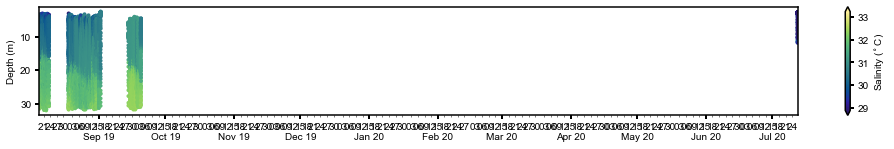

In [17]:
#bounds
lower = df['Salinity (PSU)'].mean()-3*df['Salinity (PSU)'].std()
upper = df['Salinity (PSU)'].mean()+3*df['Salinity (PSU)'].std()

#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['Salinity (PSU)'], 
                marker='o', edgecolor='none', vmin=lower, vmax=upper, cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [18]:
print("""
max sal: {0:0.4}
min sal: {1:0.4}""".format(df['Salinity (PSU)'].max(), df['Salinity (PSU)'].min()))

print("""
mean sal: {0:0.4}
sal std: {1:04}""".format(df['Salinity (PSU)'].mean(),df['Salinity (PSU)'].std()))


max sal: 36.95
min sal: 28.28

mean sal: 31.06
sal std: 0.7308296349009534


#### Chlorophyl

Text(0, 0.5, 'Depth (m)')

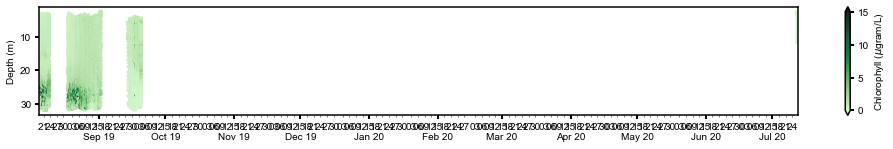

In [19]:
df['wetlab_Chlorophyll_ug/l'] = (df['wetlab_Chlorophyll']-60)*0.0226

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['wetlab_Chlorophyll_ug/l'], 
                marker='o', vmin =0, vmax= 15, edgecolor='none', cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)')


In [20]:
print("""
max chlorophyll: {0:0.4}
min chlorophyll: {1:0.4}""".format(df['wetlab_Chlorophyll_ug/l'].max(), df['wetlab_Chlorophyll_ug/l'].min()))


max chlorophyll: 64.84
min chlorophyll: 0.1356


#### Chlorophyl (log scale)

Text(0, 0.5, 'Depth (m)')

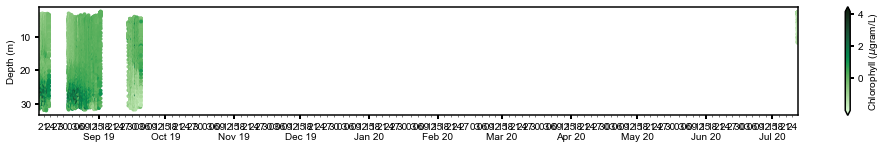

In [21]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=np.log(df['wetlab_Chlorophyll_ug/l']), 
                marker='o', edgecolor='none', cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)')

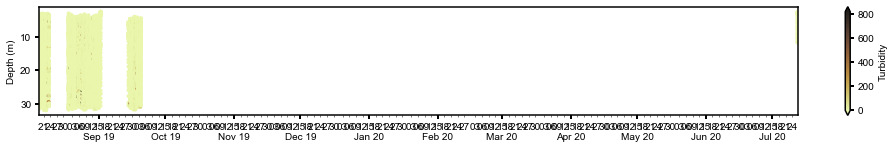

In [22]:
df['wetlab_FDOM_NTU'] = (df['wetlab_FDOM']-51)*0.2022

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['wetlab_FDOM_NTU'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.turbid)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Turbidity')
ax.set_ylabel('Depth (m)');

In [23]:
import seawater as sw
sigmat = sw.dens(s=df['Salinity (PSU)'],t=df['SB_Temp'],p=df['SB_Depth']) - 1000.

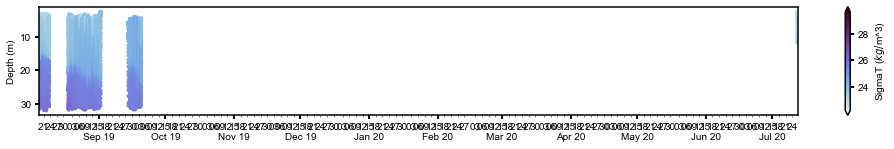

In [24]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=sigmat, 
                marker='o', edgecolor='none', cmap=cmocean.cm.dense)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('SigmaT ($kg/$m^3)')
ax.set_ylabel('Depth (m)');

In [25]:
### Oxygen with Salinity Correction

### sal correct and convert oxygen
df['O2_corr'] = optode_O2_corr.O2_sal_comp(oxygen_conc=df['Optode_Dissolved_O2'],
                                     salinity=df['Salinity (PSU)'],
                                     temperature=df['SB_Temp'])
df['O2_corr_umkg'] = optode_O2_corr.O2_molar2umkg(oxygen_conc=df.O2_corr,
                                     salinity=df['Salinity (PSU)'],
                                     temperature=df['SB_Temp'],
                                     pressure=df['SB_Depth'])

df['O2PercentSat'] = optode_O2_corr.O2PercentSat(oxygen_conc=df.O2_corr_umkg,
                                     salinity=df['Salinity (PSU)'],
                                     temperature=df['SB_Temp'],
                                     pressure=df['SB_Depth'])

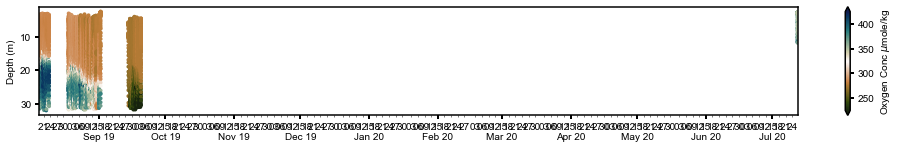

In [26]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['O2_corr_umkg'], 
                marker='o', vmin=225, vmax=425, edgecolor='none', cmap=cmocean.cm.tarn)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Conc $\mu$mole/kg')
ax.set_ylabel('Depth (m)');

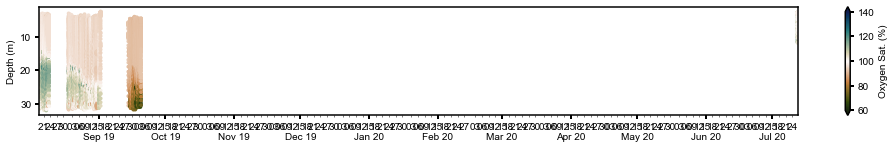

In [27]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['O2PercentSat'], 
                marker='o', vmin=60, vmax=140, edgecolor='none', cmap=cmocean.cm.tarn)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,3)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.set_ylabel('Depth (m)');

### Calibration/Characterization Profiles - last 2 days

SDIG Group doesn't want to provide a dive profile identifier
- either I need to parse the ERDDAP data via time/depth or build my own counter from rudics data

### Popup Prawler 2020 summer analysis

Prawler only had three short profiles after mooring was refloated... compare to local satellite to determine relevancy 

In [28]:
df.sample()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM,Salinity (PSU),wetlab_Chlorophyll_ug/l,wetlab_FDOM_NTU,O2_corr,O2_corr_umkg,O2PercentSat
time (UTC),,,,,,,,,,,,,
2019-09-04 07:15:37+00:00,7.45,7.285,3.147,7.282,361.64,91.0,50.0,30.571848,0.7006,-0.2022,296.346654,289.420878,96.095226


In [29]:
dfsg = df['2020-07']
dfsg.sample()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM,Salinity (PSU),wetlab_Chlorophyll_ug/l,wetlab_FDOM_NTU,O2_corr,O2_corr_umkg,O2PercentSat
time (UTC),,,,,,,,,,,,,
2020-07-26 09:39:26+00:00,3.0,1.603,2.61,1.614,455.85,76.0,50.0,29.550539,0.3616,-0.2022,372.62754,364.019594,104.531354


In [30]:
#
dfsg['divenum']=dfsg['SB_Depth'].diff()
divenum=0
for i,row in dfsg.iterrows():
    if row.divenum < -8:
        divenum+=1
    dfsg.loc[i]['divenum'] = divenum


/Users/bell/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
dfsg

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM,Salinity (PSU),wetlab_Chlorophyll_ug/l,wetlab_FDOM_NTU,O2_corr,O2_corr_umkg,O2PercentSat,divenum
time (UTC),,,,,,,,,,,,,,
2020-07-26 09:07:53+00:00,3.29,1.588,2.699,1.601,504.43,70.0,67.0,30.675415,0.2260,3.2352,409.171474,399.366736,115.632911,0.0
2020-07-26 09:08:01+00:00,2.90,1.534,2.698,1.564,503.77,78.0,50.0,30.715887,0.4068,-0.2022,408.484796,398.683312,115.311909,0.0
2020-07-26 09:08:09+00:00,3.02,1.504,2.698,1.538,502.51,73.0,53.0,30.745203,0.2938,0.4044,407.360202,397.575647,114.929365,0.0
2020-07-26 09:08:17+00:00,3.11,1.484,2.697,1.476,502.34,71.0,54.0,30.752215,0.2486,0.6066,407.188688,397.405432,114.827656,0.0
2020-07-26 09:08:25+00:00,3.00,1.482,2.695,1.514,500.37,72.0,55.0,30.729132,0.2712,0.8088,405.654453,395.915367,114.370954,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-26 12:36:34+00:00,3.05,1.270,2.484,1.276,432.94,74.0,51.0,28.286256,0.3164,0.0000,356.779008,348.876329,98.367363,4.0
2020-07-26 12:36:42+00:00,3.11,1.270,2.484,1.276,432.98,71.0,52.0,28.286226,0.2486,0.2022,356.812045,348.908544,98.376424,4.0
2020-07-26 12:36:50+00:00,2.94,1.270,2.484,1.276,433.11,71.0,51.0,28.286311,0.2486,0.0000,356.918968,349.013353,98.406040,4.0


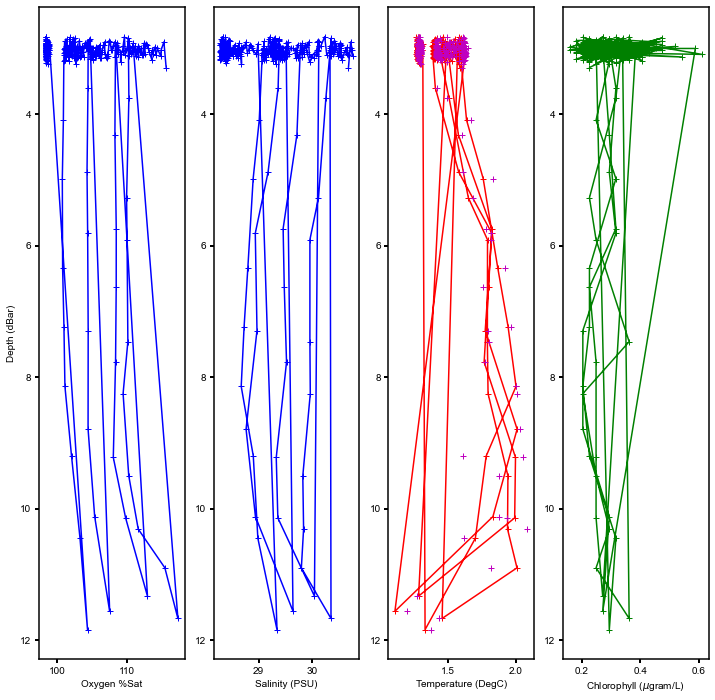

In [32]:
fig, ax = plt.subplots(1,4,figsize=(12, 12))

cs = ax[0].plot(dfsg['O2PercentSat'],dfsg['SB_Depth'],'b+-')
cs = ax[1].plot(dfsg['Salinity (PSU)'],dfsg['SB_Depth'],'b+-')
cs = ax[2].plot(dfsg['SB_Temp'],dfsg['SB_Depth'],'r+-')
cs = ax[2].plot(dfsg['Optode_Temp'],dfsg['SB_Depth'],'m+')
cs = ax[3].plot(dfsg['wetlab_Chlorophyll_ug/l'],dfsg['SB_Depth'],'g+-')

ax[0].set_xlabel('Oxygen %Sat')        
ax[0].set_ylabel('Depth (dBar)')        
ax[0].invert_yaxis()
ax[1].set_xlabel('Salinity (PSU)')        
ax[1].invert_yaxis()
ax[2].set_xlabel('Temperature (DegC)')        
ax[2].invert_yaxis()
ax[3].set_xlabel('Chlorophyll ($\mu$gram/L)')        
ax[3].invert_yaxis()

2020-07-26 09:07:53+00:00
2020-07-26 09:15:47+00:00
2020-07-26 09:21:09+00:00
2020-07-26 09:39:18+00:00
2020-07-26 12:16:34+00:00


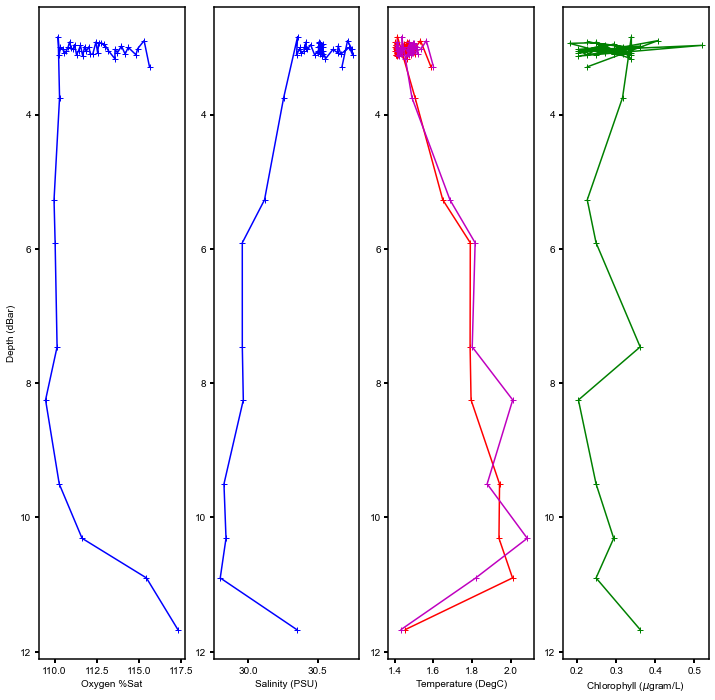

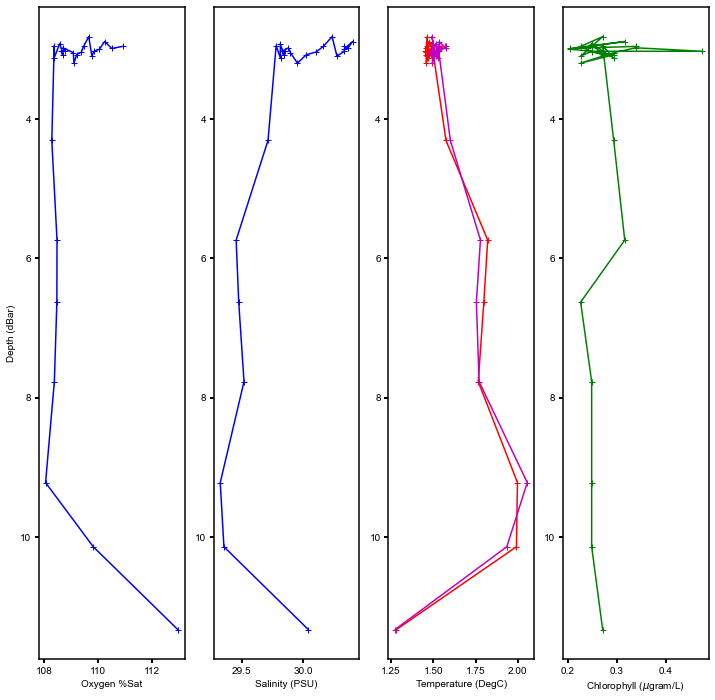

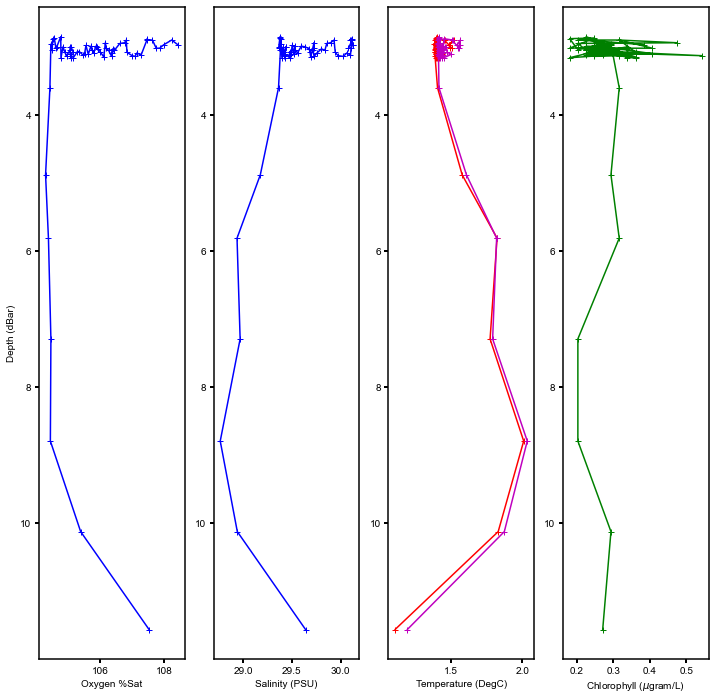

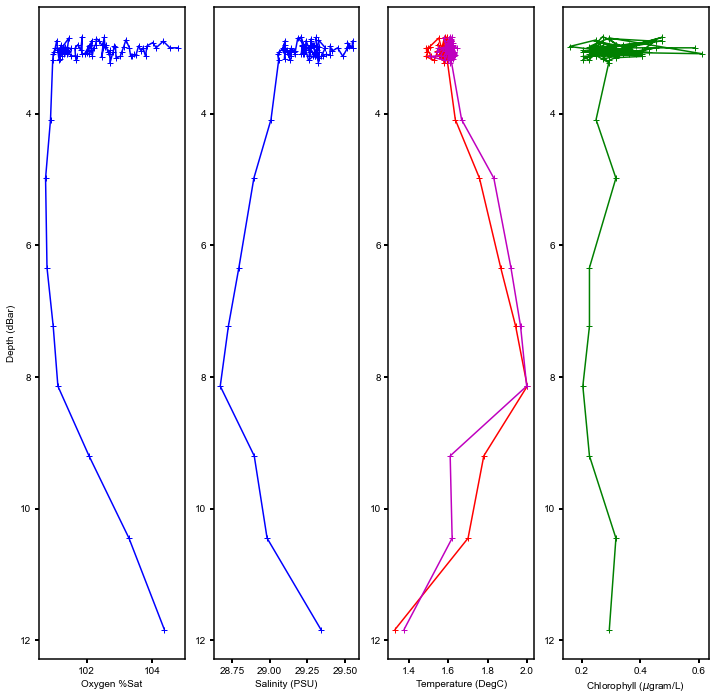

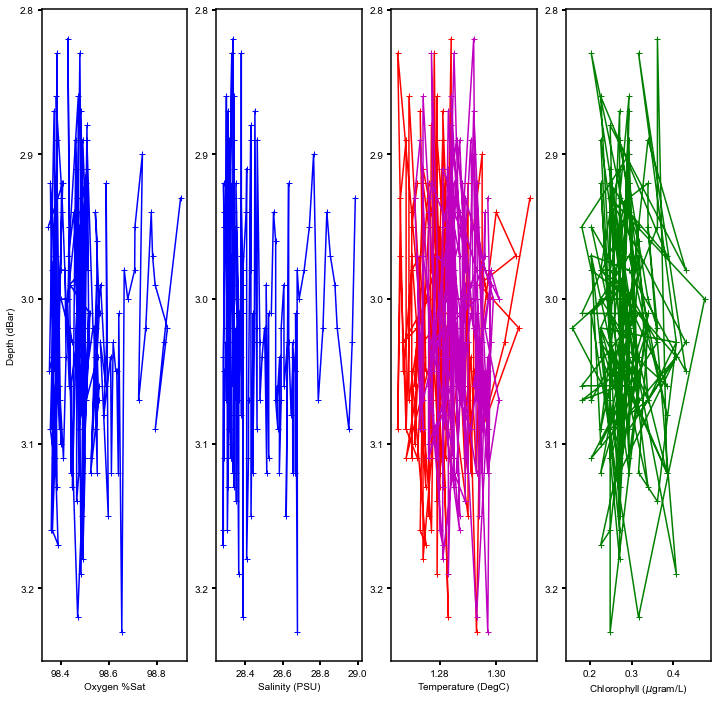

In [33]:
for i,cast in enumerate(dfsg.groupby('divenum').groups):
    print(dfsg.groupby('divenum').get_group(cast).index[0])
    fig, ax = plt.subplots(1,4,figsize=(12, 12))
    
    cs = ax[0].plot(dfsg.groupby('divenum').get_group(cast)['O2PercentSat'],
                    dfsg.groupby('divenum').get_group(cast)['SB_Depth'],'b+-')
    cs = ax[1].plot(dfsg.groupby('divenum').get_group(cast)['Salinity (PSU)'],
                    dfsg.groupby('divenum').get_group(cast)['SB_Depth'],'b+-')
    cs = ax[2].plot(dfsg.groupby('divenum').get_group(cast)['SB_Temp'],
                    dfsg.groupby('divenum').get_group(cast)['SB_Depth'],'r+-')
    cs = ax[2].plot(dfsg.groupby('divenum').get_group(cast)['Optode_Temp'],
                    dfsg.groupby('divenum').get_group(cast)['SB_Depth'],'m+-')
    cs = ax[3].plot(dfsg.groupby('divenum').get_group(cast)['wetlab_Chlorophyll_ug/l'],
                    dfsg.groupby('divenum').get_group(cast)['SB_Depth'],'g+-')

    ax[0].set_xlabel('Oxygen %Sat')        
    ax[0].set_ylabel('Depth (dBar)')        
    ax[0].invert_yaxis()
    ax[1].set_xlabel('Salinity (PSU)')        
    ax[1].invert_yaxis()
    ax[2].set_xlabel('Temperature (DegC)')        
    ax[2].invert_yaxis()
    ax[3].set_xlabel('Chlorophyll ($\mu$gram/L)')        
    ax[3].invert_yaxis()
    
    fig.savefig('divenum_'+str(cast)+'.png')